In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import os
import astropy.io.fits as fits
from astropy.table import Table
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask
from desiutil.plots import prepare_data, init_sky, plot_sky_circles, plot_sky_binned
from desiutil.log import get_logger
import warnings
import mpl_toolkits
%matplotlib inline

These are some of the questions we want to address by exploring the simulation outputs from the `quicksurvey2017` run.

### BGS

* Distribution of exposure times
* The fraction of targets that receive a fibre versus 
    - magnitude (presumably just a step function at 19.5); 
    - density on the sky (either Healpix or the tile) 
    - RA 
    - dec 
    - galactic latitude 
    - stellar density
* The above separately for r<19.5 and 19.5<r<20 targets
* Redshift success rate versus exposure time  

In [4]:
topdir = os.path.join("/project/projectdirs/desi/users/jguy/mocks/darksky-v1.0.1-v2/")
truthfile = os.path.join(topdir, 'targets-1/truth.fits')
targetfile = os.path.join(topdir, 'targets-1/mtl.fits')
skyfile = os.path.join(topdir, 'targets-1/sky.fits')
stdstarsfile = os.path.join(topdir, 'targets-1/standards-bright.fits')
stdstarsdarkfile = os.path.join(topdir, 'targets-1/standards-dark.fits')


In [5]:
targets  = fits.getdata(targetfile)
truth = fits.getdata(truthfile)
stddark = fits.getdata(stdstarsdarkfile)
stdbright = fits.getdata(stdstarsfile)

In [6]:
Table(targets[0:1])

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,NUMOBS_MORE,PRIORITY,OBSCONDITIONS
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64,int64,int64,int64,int32,int64,int32
0,0448p002,0,44.9809570312,0.300254672766,1.03217,1.37144,2.84508,4.13127,2.42853,0.802469,0.862227,0.919798,0.987481,0.992293,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.00136156,-1.73441e-05,-0.000745189,0.444634,-0.000223009,0.000645852,0.239550627406,288230376151711744,131074,0,0,0,1,3000,3


In [7]:
Table(stddark[0:1])

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,OBSCONDITIONS
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64,int64,int64,int64,int64
0,0448p002,9718,44.9810035993,0.2622608369,399.302,304.173,192.916,22.9954,12.1634,0.800762,0.86099,0.919054,0.98736,0.992218,52.4807,7.72681,1.87068,57.544,13.1826,2.51189,0.0276732,0.438591,0.0,0.0,0.0,0.0,0.0,0.0,0.671874652697,288230376151721462,2305843026393563136,0,2,0,3


In [8]:
Table(truth[0:1])

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,VDISP,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
288230376151711744,10518700,0,0.684509,GALAXY,ELG,,-1,790179425,22.0321,-1.0,1.28983,1.53872,3.19647,3.5366,2.4042,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
desi_mask.names()
for name in mws_mask.names():
    ii = (stdbright['MWS_TARGET'] & mws_mask.mask(name))!=0
    print(name, np.count_nonzero(ii))

MWS_MAIN 0
MWS_WD 65618
MWS_NEARBY 0
MWS_MAIN_VERY_FAINT 0


In [10]:
contam = truth['CONTAM_TARGET']!=0
contam_list = list(set(truth['CONTAM_TARGET'][contam]))
print(contam_list)

[2097160, 1048577, 10486792, 8389632]


In [11]:
contam_mask.names()
print('The following contaminants flags were found in truth:')
contam_active_flags = []
for c in contam_list:
    for contam_name in contam_mask.names():
        if (c & contam_mask.mask(contam_name)!=0):
            ii = (truth['CONTAM_TARGET'] & contam_mask.mask(contam_name)) !=0
            print('{}: {} objects'.format(contam_name, np.count_nonzero(ii)))
            contam_active_flags.append(contam_name)

The following contaminants flags were found in truth:
ELG_IS_STAR: 1251184 objects
ELG_CONTAM: 1251184 objects
BGS_IS_STAR: 5110196 objects
BGS_CONTAM: 5110196 objects
ELG_IS_STAR: 1251184 objects
QSO_IS_STAR: 124987 objects
ELG_CONTAM: 1251184 objects
QSO_CONTAM: 124987 objects
QSO_IS_STAR: 124987 objects
QSO_CONTAM: 124987 objects


2669818
2669818
2794805


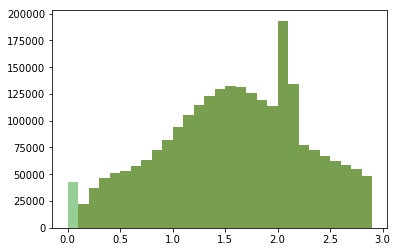

In [12]:
galtype = 'QSO'
these = (truth['TEMPLATETYPE']==galtype)
print(np.count_nonzero(these))
a = plt.hist(truth['TRUEZ'][these], alpha=0.5, bins=np.arange(0,3,0.1))

these = (truth['TEMPLATETYPE']==galtype) & (truth['CONTAM_TARGET']==0)
print(np.count_nonzero(these))
a = plt.hist(truth['TRUEZ'][these], alpha=0.5, bins=np.arange(0,3,0.1))

these = (targets['DESI_TARGET'] & desi_mask.mask(galtype))!=0
ii = np.in1d(truth['TARGETID'], targets['TARGETID'][these])
print(np.count_nonzero(ii))
a = plt.hist(truth['TRUEZ'][ii], alpha=0.5, bins=np.arange(0,3,0.1))


2669818


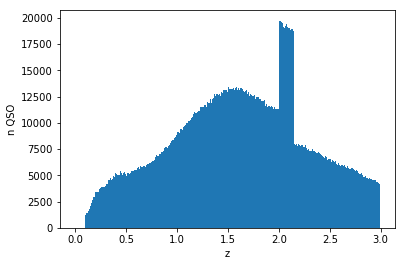

In [14]:
these = (truth['TRUESPECTYPE']=='QSO')
print(np.count_nonzero(these))
a = plt.hist(truth['TRUEZ'][these], bins=np.arange(0,3,0.01))
plt.xlabel("z")
plt.ylabel("n QSO")

In [18]:
def qadensity(cat, objtype, targdens=None, max_bin_area=10.0):
    label = '{} (targets/deg$^2$)'.format(objtype)
    if targdens:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots(1)
    ax = np.atleast_1d(ax)
    
    basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
    basemap, data = plot_sky_binned(cat['RA'], cat['DEC'], max_bin_area=max_bin_area,
                                    clip_lo='!1', cmap='jet', plot_type='healpix', 
                                    label=label, basemap=basemap, return_grid_data=True)
    if targdens:
        dens = data[np.nonzero(data)]
        ax[1].hist(dens, bins=40, histtype='stepfilled', alpha=0.6, label='Observed {} Density'.format(objtype))
        if objtype in targdens.keys():
            ax[1].axvline(x=targdens[objtype], ls='--', color='k', label='Goal {} Density'.format(objtype))
        ax[1].set_xlabel(label)
        ax[1].set_ylabel('Number of Healpixels')
        ax[1].legend(loc='upper left', frameon=False)
        fig.subplots_adjust(wspace=0.2)
    return dens

In [19]:
# Desired target densities, including contaminants.
targdens = {'ELG': 2400, 'LRG': 350, 'QSO': 260, 'SKY': 1400}

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


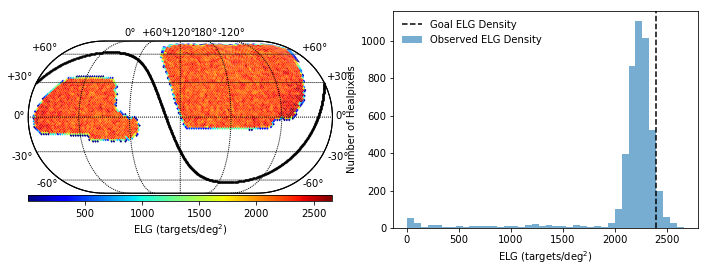

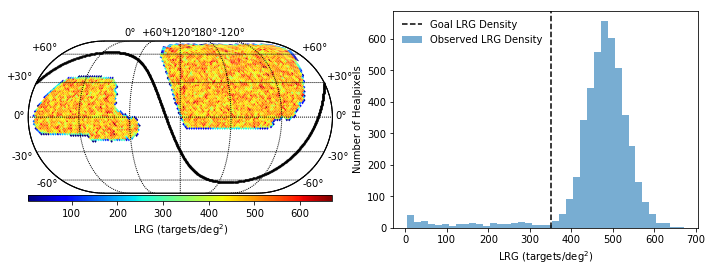

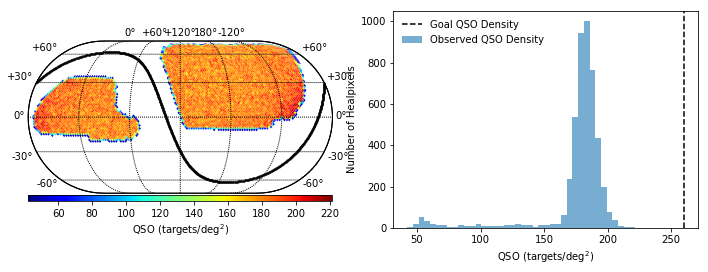

In [20]:
for obj in ['ELG','LRG','QSO']:
    these = (targets['DESI_TARGET'] & desi_mask.mask(obj)) != 0
    dd = targets[these]
    a = qadensity(dd, obj, targdens=targdens)